In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import re 
import string
import tensorflow as tf
import Preprocesing

In [2]:
# sadness (0), joy (1), love (2), anger (3), fear (4), and surprise (5).

In [3]:
df = pd.read_csv("emotions.csv")
df

,text,label
0,i just feel really helpless and heavy hearted,4
1,ive enjoyed being able to slouch about relax a...,0
2,i gave up my internship with the dmrg and am f...,4
3,i dont know i feel so lost,0
4,i am a kindergarten teacher and i am thoroughl...,4
...,...,...
416804,i feel like telling these horny devils to find...,2
416805,i began to realize that when i was feeling agi...,3
416806,i feel very curious be why previous early dawn...,5
416807,i feel that becuase of the tyranical nature of...,3


In [4]:
df.isnull().sum()

text     0
label    0
dtype: int64

In [5]:
print( f"number of duplicated values = {df.duplicated().sum()}")
df.drop_duplicates(inplace=True)
# print( f"number of duplicated values = {df.duplicated().sum()}")


number of duplicated values = 686


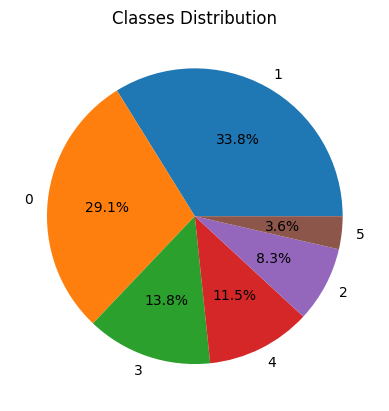

In [6]:
# df["label"].value_counts()

plt.title("Classes Distribution")
plt.pie(df["label"].value_counts(),labels=df["label"].value_counts().keys(),autopct="%1.1f%%")
plt.show()


### ✅ Lowering Text


In [7]:
df["ClenedText"] = df["text"].apply(lambda x:x.lower())
df

,text,label,ClenedText
0,i just feel really helpless and heavy hearted,4,i just feel really helpless and heavy hearted
1,ive enjoyed being able to slouch about relax a...,0,ive enjoyed being able to slouch about relax a...
2,i gave up my internship with the dmrg and am f...,4,i gave up my internship with the dmrg and am f...
3,i dont know i feel so lost,0,i dont know i feel so lost
4,i am a kindergarten teacher and i am thoroughl...,4,i am a kindergarten teacher and i am thoroughl...
...,...,...,...
416804,i feel like telling these horny devils to find...,2,i feel like telling these horny devils to find...
416805,i began to realize that when i was feeling agi...,3,i began to realize that when i was feeling agi...
416806,i feel very curious be why previous early dawn...,5,i feel very curious be why previous early dawn...
416807,i feel that becuase of the tyranical nature of...,3,i feel that becuase of the tyranical nature of...


In [8]:
CleanedColumn = Preprocesing.Process_column(Column_name="ClenedText",Dataset=df)

### ✅ Remove Any words like (`don t`, `can t`, `didn t` and so on..... )

In [9]:
df["text"].apply(lambda x:re.findall(r"\b[a-z]+n\s+t\b",string=x)).value_counts()


text
[]                             395053
[don t]                          8210
[can t]                          2884
[didn t]                         2593
[wasn t]                          906
                                ...  
[when t]                            1
[couldn t, can t, wasn t]           1
[haven t, didn t, couldn t]         1
[can t, can t, weren t]             1
[can t, didn t, hadn t]             1
Name: count, Length: 319, dtype: int64

In [10]:
df["ClenedText"] = df["text"].apply(lambda x:re.sub(pattern=r"\b[a-z]+n\s+t\b",repl=" ",string=x))

### ✅ Rmoving StopWords


In [11]:
from nltk.tokenize import word_tokenize

CleanedColumn.Updeate_column(lambda x: word_tokenize(x))
df["ClenedText"]

0         [i, just, feel, really, helpless, and, heavy, ...
1         [ive, enjoyed, being, able, to, slouch, about,...
2         [i, gave, up, my, internship, with, the, dmrg,...
3                        [i, dont, know, i, feel, so, lost]
4         [i, am, a, kindergarten, teacher, and, i, am, ...
                                ...                        
416804    [i, feel, like, telling, these, horny, devils,...
416805    [i, began, to, realize, that, when, i, was, fe...
416806    [i, feel, very, curious, be, why, previous, ea...
416807    [i, feel, that, becuase, of, the, tyranical, n...
416808    [i, think, that, after, i, had, spent, some, t...
Name: ClenedText, Length: 416123, dtype: object

In [12]:
from nltk.corpus import stopwords

_stopwords = stopwords.words("english")
_stopwords

['a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 "he'd",
 "he'll",
 'her',
 'here',
 'hers',
 'herself',
 "he's",
 'him',
 'himself',
 'his',
 'how',
 'i',
 "i'd",
 'if',
 "i'll",
 "i'm",
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it'd",
 "it'll",
 "it's",
 'its',
 'itself',
 "i've",
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'on

In [13]:
def remove_Stopwords(string:str):
    return [x for x in string if x not in _stopwords]


CleanedColumn.Updeate_column(lambda x:remove_Stopwords(x))
df["ClenedText"]


0                  [feel, really, helpless, heavy, hearted]
1         [ive, enjoyed, able, slouch, relax, unwind, fr...
2             [gave, internship, dmrg, feeling, distraught]
3                                  [dont, know, feel, lost]
4         [kindergarten, teacher, thoroughly, weary, job...
                                ...                        
416804    [feel, like, telling, horny, devils, find, sit...
416805    [began, realize, feeling, agitated, restless, ...
416806    [feel, curious, previous, early, dawn, time, s...
416807    [feel, becuase, tyranical, nature, government,...
416808    [think, spent, time, investigating, surroundin...
Name: ClenedText, Length: 416123, dtype: object

### ✅ Rmoving any word like (`ive` , `im` , `its` , `dont` and so on .......)


In [14]:
df["ClenedText"].apply(lambda x:re.findall(pattern=r"\b(ive|im|its|dont)\b",string=" ".join(x)))

0             []
1          [ive]
2             []
3         [dont]
4             []
           ...  
416804        []
416805        []
416806        []
416807        []
416808        []
Name: ClenedText, Length: 416123, dtype: object

In [15]:
CleanedColumn.Updeate_column(lambda x:re.sub(pattern=r"\b(ive|im|its|dont)\b",repl=" ",string=" ".join(x)))
df["ClenedText"]

0                        feel really helpless heavy hearted
1           enjoyed able slouch relax unwind frankly nee...
2                   gave internship dmrg feeling distraught
3                                            know feel lost
4         kindergarten teacher thoroughly weary job take...
                                ...                        
416804    feel like telling horny devils find site suite...
416805    began realize feeling agitated restless would ...
416806    feel curious previous early dawn time seek tro...
416807    feel becuase tyranical nature government el sa...
416808    think spent time investigating surroundings th...
Name: ClenedText, Length: 416123, dtype: object